In [220]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [221]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.5f}'.format

# 데이터 불러오기

In [222]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
car_2020 = pd.read_csv('data/car_2020.csv',encoding='cp949')
age = pd.read_csv('data/age_gender_info.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [223]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72000,134,38.00000,A,15667000,103680,0.00000,3.00000,1425.00000,1015.00000
1,C2483,900,아파트,경상북도,국민임대,39.72000,15,38.00000,A,15667000,103680,0.00000,3.00000,1425.00000,1015.00000
2,C2483,900,아파트,경상북도,국민임대,51.93000,385,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000
3,C2483,900,아파트,경상북도,국민임대,51.93000,15,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000
4,C2483,900,아파트,경상북도,국민임대,51.93000,41,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000


In [224]:
a = pd.qcut(train['총세대수'],3,labels=[1,2,3]) # 소단지,중단지,대단지
train.insert(14,'단지규모',a)

In [225]:
train['총세대수'] = np.log(train['총세대수'])

car_2020 = car_2020.drop(['시군구(1)'], axis=1)
car_2020.columns = ['지역','월','항목','분류','자동차수']
car_2020['월'] = pd.to_datetime(car_2020['월']).dt.month
car_2020.head()

In [226]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
단지규모                              0
등록차량수                             0
dtype: int64

In [227]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

pd.concat([train.자격유형.value_counts(),
           test.자격유형.value_counts()], axis=1)

,자격유형,자격유형
A,1801,573
D,569,180
국민임대/장기전세_공급대상,222,103
행복주택_공급대상,213,124
영구임대_공급대상,147,42


In [228]:
train_copy = train.copy()
train_copy = pd.get_dummies(train_copy,columns=['자격유형'])
del train_copy['등록차량수']
train_copy['등록차량수'] = train['등록차량수']
train = train_copy

In [229]:
train.head(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,단지규모,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,등록차량수
0,C2483,6.80239,아파트,경상북도,국민임대,39.72000,134,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
1,C2483,6.80239,아파트,경상북도,국민임대,39.72000,15,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
2,C2483,6.80239,아파트,경상북도,국민임대,51.93000,385,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
3,C2483,6.80239,아파트,경상북도,국민임대,51.93000,15,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
4,C2483,6.80239,아파트,경상북도,국민임대,51.93000,41,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000


# 컬럼명 바꿔주기

In [230]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '단지규모', 'A', 'D', '국민임대/장기전세', '영구임대', '행복주택', '등록차량수'
]

In [231]:
train.head(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택,등록차량수
0,C2483,6.80239,아파트,경상북도,국민임대,39.72000,134,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
1,C2483,6.80239,아파트,경상북도,국민임대,39.72000,15,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
2,C2483,6.80239,아파트,경상북도,국민임대,51.93000,385,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
3,C2483,6.80239,아파트,경상북도,국민임대,51.93000,15,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
4,C2483,6.80239,아파트,경상북도,국민임대,51.93000,41,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000


# 지하철 Y or N로 변경

In [232]:
train['지하철'] = train['지하철'].fillna(0)
train['지하철'] = np.where(train['지하철'] == 0, 0, 1)

# 결측치 처리

In [233]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
train.loc[train.임대료=='-', '임대료'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
train['임대료'] = train['임대료'].astype(float)
train['임대보증금'] = train['임대보증금'].fillna(0)
train['임대료'] = train['임대료'].fillna(0)

In [234]:
train['버스'] = train['버스'].fillna(train['버스'].mean())

In [235]:
train.isnull().sum()

단지코드         0
총세대수         0
임대건물구분       0
지역           0
공급유형         0
전용면적         0
전용면적별세대수     0
공가수          0
임대보증금        0
임대료          0
지하철          0
버스           0
단지내주차면수      0
단지규모         0
A            0
D            0
국민임대/장기전세    0
영구임대         0
행복주택         0
등록차량수        0
dtype: int64

# 임대건물구분 : 아파트->상가 / 전용면적별세대수 : x->1

In [236]:
idx = train[(train['임대건물구분']=='아파트') & (train['D']=='D')]['전용면적별세대수'].index
train.loc[idx, '전용면적별세대수'] = 1
train.loc[idx, '임대건물구분'] = '상가'

In [237]:
# 원핫 인코딩
#train = pd.get_dummies(data = train, columns = ['지하철'])

# 지역명 숫자로 매핑

In [238]:
local_map = {}
for i, loc in enumerate(train['지역'].unique()):
    local_map[loc] = i
    
train['지역'] = train['지역'].map(local_map)

# 전용면적을 5의 배수로 변경

In [239]:
train['전용면적'] = train['전용면적']//5*5

# 전용면적 상/하한 적용

In [240]:
idx = train[train['전용면적']>100].index
train.loc[idx, '전용면적'] = 100

idx = train[train['전용면적']<15].index
train.loc[idx, '전용면적'] = 15

In [241]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   단지코드       2952 non-null   object  
 1   총세대수       2952 non-null   float64 
 2   임대건물구분     2952 non-null   object  
 3   지역         2952 non-null   int64   
 4   공급유형       2952 non-null   object  
 5   전용면적       2952 non-null   float64 
 6   전용면적별세대수   2952 non-null   int64   
 7   공가수        2952 non-null   float64 
 8   임대보증금      2952 non-null   float64 
 9   임대료        2952 non-null   float64 
 10  지하철        2952 non-null   int32   
 11  버스         2952 non-null   float64 
 12  단지내주차면수    2952 non-null   float64 
 13  단지규모       2952 non-null   category
 14  A          2952 non-null   uint8   
 15  D          2952 non-null   uint8   
 16  국민임대/장기전세  2952 non-null   uint8   
 17  영구임대       2952 non-null   uint8   
 18  행복주택       2952 non-null   uint8   
 19  등록차량수      2952 non-null   

# test 불러오기

In [242]:
a = pd.qcut(test['총세대수'],3,labels=[1,2,3]) # 소단지,중단지,대단지
test.insert(14,'단지규모',a)

In [243]:
test_copy = test.copy()
test_copy = pd.get_dummies(test_copy,columns=['자격유형'])
test = test_copy

In [244]:
test

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,단지규모,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
0,C1072,754,아파트,경기도,국민임대,39.79000,116,14.00000,22830000,189840,0.00000,2.00000,683.00000,2,0,0,1,0,0
1,C1072,754,아파트,경기도,국민임대,46.81000,30,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,1,0,0,0,0
2,C1072,754,아파트,경기도,국민임대,46.90000,112,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,0,0,1,0,0
3,C1072,754,아파트,경기도,국민임대,46.90000,120,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,0,0,1,0,0
4,C1072,754,아파트,경기도,국민임대,51.46000,60,14.00000,43497000,296780,0.00000,2.00000,683.00000,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,C1267,675,아파트,경상남도,행복주택,36.77000,126,38.00000,-,-,0.00000,1.00000,467.00000,2,0,0,0,0,1
1018,C2189,382,아파트,전라북도,국민임대,29.19000,96,45.00000,6872000,106400,0.00000,2.00000,300.00000,1,0,0,1,0,0
1019,C2189,382,아파트,전라북도,국민임대,29.19000,20,45.00000,6872000,106400,0.00000,2.00000,300.00000,1,0,0,1,0,0
1020,C2189,382,아파트,전라북도,국민임대,39.45000,202,45.00000,13410000,144600,0.00000,2.00000,300.00000,1,0,0,1,0,0


In [245]:
test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '단지규모' , 'A', 'D', '국민임대/장기전세', '영구임대', '행복주택'
]

In [246]:
test.isnull().sum()

단지코드           0
총세대수           0
임대건물구분         0
지역             0
공급유형           0
전용면적           0
전용면적별세대수       0
공가수            0
임대보증금        180
임대료          180
지하철           42
버스             0
단지내주차면수        0
단지규모           0
A              0
D              0
국민임대/장기전세      0
영구임대           0
행복주택           0
dtype: int64

In [247]:
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
test['임대보증금'] = test['임대보증금'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)
test['임대보증금'] = test['임대보증금'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [248]:
test['지하철'].value_counts()

0.00000    881
1.00000     64
2.00000     35
Name: 지하철, dtype: int64

In [249]:
test['지하철'] = test['지하철'].fillna(0)
test['지하철'] = np.where(test['지하철'] == 0, 0, 1)

In [250]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택
0,C1072,754,아파트,경기도,국민임대,39.79000,116,14.00000,22830000.00000,189840.00000,0,2.00000,683.00000,2,0,0,1,0,0
1,C1072,754,아파트,경기도,국민임대,46.81000,30,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,1,0,0,0,0
2,C1072,754,아파트,경기도,국민임대,46.90000,112,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,0,0,1,0,0
3,C1072,754,아파트,경기도,국민임대,46.90000,120,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,0,0,1,0,0
4,C1072,754,아파트,경기도,국민임대,51.46000,60,14.00000,43497000.00000,296780.00000,0,2.00000,683.00000,2,0,0,1,0,0


In [251]:
local_map = {}
for i, loc in enumerate(test['지역'].unique()):
    local_map[loc] = i
    
test['지역'] = test['지역'].map(local_map)

In [252]:
test['전용면적'] = test['전용면적']//5*5

idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = test[test['전용면적']<15].index
test.loc[idx, '전용면적'] = 15

In [253]:
test.isnull().sum()

단지코드         0
총세대수         0
임대건물구분       0
지역           0
공급유형         0
전용면적         0
전용면적별세대수     0
공가수          0
임대보증금        0
임대료          0
지하철          0
버스           0
단지내주차면수      0
단지규모         0
A            0
D            0
국민임대/장기전세    0
영구임대         0
행복주택         0
dtype: int64

In [254]:
columns = ['총세대수', '지역', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수', '단지규모']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique():
    area_columns.append(f'면적_{area}')

In [255]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [256]:
new_train['임대보증금'] = 0
new_train['임대료'] = 0
new_test['임대보증금'] = 0
new_test['임대료'] = 0

## 수정한 코드

In [257]:
# Train Dataframe Set
# 미사용 열s - 임대건물구분, 공급유형, 자격유형 임대보증금, 임대료
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0]) # index 재설정
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col] # Fixed Data
    
    deposit_cost = []
    rental_cost = []

    for col in area_columns:
        area = float(col.split('_')[-1]) # 면적의 숫자를 float형으로 저장
        # '면적_10' 등의 열을 만들고 - 같은 전용면적들 끼리 전용면적별세대수의 합을 Value로 Cell에 입력
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
        
        try:
          deposit_cost.append(temp[temp['전용면적']==area]['임대보증금'][0])
          rental_cost.append(temp[temp['전용면적']==area]['임대료'][0])
        except KeyError as e:
          continue
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    # print(type(deposit_cost[0]))
    new_train.loc[i, '임대보증금'] = int(np.mean(deposit_cost))
    new_train.loc[i, '임대료'] = int(np.mean(rental_cost))

# Test DataFrame Set
# 미사용 열s - 임대건물구분, 공급유형, 자격유형 임대보증금, 임대료, 등록차량수
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]

    deposit_cost = []
    rental_cost = []
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
        
        try:
          deposit_cost.append(temp[temp['전용면적']==area]['임대보증금'][0])
          rental_cost.append(temp[temp['전용면적']==area]['임대료'][0])
        except KeyError as e:
          continue
          
    new_test.loc[i, '임대보증금'] = int(np.mean(deposit_cost))
    new_test.loc[i, '임대료'] = int(np.mean(rental_cost))


# 추가해볼 것 임대보증금 , 임대료 Column 만들고 평균

423it [00:08, 48.12it/s]
150it [00:03, 46.33it/s]


In [259]:
new_train_s = new_train[new_train['단지규모'] == 1]
new_train_m = new_train[new_train['단지규모'] == 2]
new_train_l = new_train[new_train['단지규모'] == 3]

In [260]:
new_train_s.shape, new_train_m.shape, new_train_l.shape

((193, 26), (145, 26), (85, 26))

In [261]:
x_new_train_s = new_train_s.iloc[:, :-1]
x_new_train_m = new_train_m.iloc[:, :-1]
x_new_train_l = new_train_l.iloc[:, :-1]

y_new_train_s = new_train_s.iloc[:, -1]
y_new_train_m = new_train_m.iloc[:, -1]
y_new_train_l = new_train_l.iloc[:, -1]

x_test = new_test

In [178]:
# x_train = new_train.iloc[:, :-1]
# y_train = new_train.iloc[:,-1]
# x_test = new_test

In [179]:
# from sklearn.linear_model import LinearRegression

# linear_s = LinearRegression()
# linear_m = LinearRegression()
# linear_l = LinearRegression()

# linear_s.fit(x_new_train_s, y_new_train_s)
# linear_m.fit(x_new_train_m, y_new_train_m)
# linear_l.fit(x_new_train_l, y_new_train_l)

LinearRegression()

In [278]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

linear_s = LinearRegression()
forest_m = RandomForestRegressor(random_state=0)
logisctic_l = LogisticRegression()

linear_s.fit(x_new_train_s, y_new_train_s)
forest_m.fit(x_new_train_m, y_new_train_m)
logisctic_l.fit(x_new_train_l, y_new_train_l)

C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [180]:
# forest_s = RandomForestRegressor(n_jobs=-1, random_state=42)
# forest_m = RandomForestRegressor(n_jobs=-1, random_state=42)
# forest_l = RandomForestRegressor(n_jobs=-1, random_state=42)

# forest_s.fit(x_new_train_s, y_new_train_s)
# forest_m.fit(x_new_train_m, y_new_train_m)
# forest_l.fit(x_new_train_l, y_new_train_l)

In [181]:
# forest.fit(x_train, y_train)

In [279]:
x_test_s = x_test[x_test['단지규모'] == 1]
x_test_m = x_test[x_test['단지규모'] == 2]
x_test_l = x_test[x_test['단지규모'] == 3]

x_test_s_idx = x_test[x_test['단지규모'] == 1].index
x_test_m_idx = x_test[x_test['단지규모'] == 2].index
x_test_l_idx = x_test[x_test['단지규모'] == 3].index

In [280]:
pred_s = linear_s.predict(x_test_s)
pred_m = forest_m.predict(x_test_m)
pred_l = logisctic_l.predict(x_test_l)

In [183]:
# pred_s = linear_s.predict(x_test_s)
# pred_m = linear_m.predict(x_test_m)
# pred_l = linear_l.predict(x_test_l)

In [202]:
# pred_s = forest_s.predict(x_test_s)
# pred_m = forest_m.predict(x_test_m)
# pred_l = forest_l.predict(x_test_l)

In [281]:
submission.loc[x_test_s_idx, 'num'] = pred_s
submission.loc[x_test_m_idx, 'num'] = pred_m
submission.loc[x_test_l_idx, 'num'] = pred_l

In [282]:
submission.isnull().sum()

code    0
num     0
dtype: int64

In [283]:
submission

,code,num
0,C1072,742.19000
1,C1128,1101.00000
2,C1456,623.79000
3,C1840,525.11000
4,C1332,1804.00000
...,...,...
145,C2456,9630.94905
146,C1266,498.57000
147,C2152,3198.96307
148,C1267,447.66000


In [188]:
# pred = forest.predict(x_test)

In [189]:
# submission['num'] = pred

In [190]:
submission.to_csv('./신분OneHot_등록차량수_주차면수_단지규모.csv', index=False)

In [276]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

x_new_train_s = new_train_s.iloc[:, :-1]
x_new_train_m = new_train_m.iloc[:, :-1]
x_new_train_l = new_train_l.iloc[:, :-1]

y_new_train_s = new_train_s.iloc[:, -1]
y_new_train_m = new_train_m.iloc[:, -1]
y_new_train_l = new_train_l.iloc[:, -1]

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_new_train_s, y_new_train_s, random_state=42)
x_train_m, x_test_m, y_train_m, y_test_m = train_test_split(x_new_train_m, y_new_train_m, random_state=42)
x_train_l, x_test_l, y_train_l, y_test_l = train_test_split(x_new_train_l, y_new_train_l, random_state=42)

# forest_s1 = LinearRegression()
# forest_m1 = LinearRegression()

forest_s1 = RandomForestRegressor(random_state=0)
forest_m1 = RandomForestRegressor(random_state=0)
forest_l1 = RandomForestRegressor(random_state=0)

forest_s1.fit(x_train_s, y_train_s)
forest_m1.fit(x_train_m, y_train_m)
forest_l1.fit(x_train_l, y_train_l)

pred_s1 = forest_s1.predict(x_test_s)
pred_m1 = forest_m1.predict(x_test_m)
pred_l1 = forest_l1.predict(x_test_l)

s_val = mean_absolute_error(y_test_s, pred_s1)
m_val = mean_absolute_error(y_test_m, pred_m1)
l_val = mean_absolute_error(y_test_l, pred_l1)

In [277]:
print('s_val : ', s_val)
print('m_val : ', m_val)
print('l_val : ', l_val)

s_val :  77.71183673469389
m_val :  163.11918918918917
l_val :  206.98954545454546


In [191]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
x = new_train.iloc[:, :-1]
y = new_train.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
forest = RandomForestRegressor(random_state=0)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
mean_absolute_error(y_test, pred)

131.0185849056604

# 시각화

In [192]:
pd.set_option('max_columns', 30)
new_train

,임대보증금,임대료,총세대수,지역,전용면적별세대수,공가수,지하철,버스,단지내주차면수,단지규모,면적_35.0,면적_50.0,면적_55.0,면적_30.0,면적_45.0,면적_40.0,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0,등록차량수
0,15667000.00000,103680.00000,6.80239,0.00000,134.00000,38.00000,0.00000,3.00000,1425.00000,2.00000,149.00000,665.00000,86.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1015.00000
1,9216000.00000,82940.00000,6.30079,1.00000,276.00000,17.00000,0.00000,3.00000,624.00000,1.00000,80.00000,132.00000,0.00000,276.00000,57.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,205.00000
2,15620000.00000,127350.00000,7.10332,2.00000,288.00000,13.00000,1.00000,1.00000,1285.00000,3.00000,0.00000,124.00000,0.00000,390.00000,340.00000,362.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1064.00000
3,15607000.00000,130070.00000,6.62672,3.00000,120.00000,6.00000,1.00000,3.00000,734.00000,2.00000,240.00000,303.00000,212.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,730.00000
4,12015000.00000,102130.00000,6.54535,4.00000,228.00000,14.00000,0.00000,2.00000,645.00000,2.00000,254.00000,246.00000,0.00000,0.00000,196.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,553.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,16800000.00000,71400.00000,4.49981,9.00000,12.00000,7.00000,0.00000,3.00000,66.00000,1.00000,36.00000,0.00000,0.00000,0.00000,0.00000,0.00000,42.00000,0.00000,12.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,57.00000
419,10000000.00000,117000.00000,6.19848,5.00000,132.00000,24.00000,0.00000,1.00000,521.00000,1.00000,156.00000,0.00000,0.00000,0.00000,180.00000,0.00000,156.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,246.00000
420,18000000.00000,87000.00000,3.68888,8.00000,20.00000,7.00000,1.00000,2.00000,25.00000,1.00000,15.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,0.00000,20.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,19.00000
421,10346000.00000,107530.00000,4.49981,11.00000,90.00000,12.00000,0.00000,1.00000,30.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,90.00000,0.00000,0.00000,0.00000,0.00000,0.00000,16.00000


In [290]:
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()

In [326]:
# >>> from sklearn.preprocessing import MinMaxScaler
# >>> data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
# >>> scaler = MinMaxScaler()
# >>> print(scaler.fit(data))

# 임대보증금, 임대료, 총세대수 - minmax
# 단지내주차면수 - robust

# length1 = len(new_train_copy['임대료'].to_numpy())
# print(length1)
# new_train_copy['임대료'].to_numpy().reshape(length1, -1)
# new_train_copy = new_train.copy()

scale = minMaxScaler.fit_transform(new_train_copy['임대료'].values.reshape(-1, 1))
new_train_copy['임대료'] = scale
scale = minMaxScaler.fit_transform(new_train_copy['임대보증금'].values.reshape(-1, 1))
new_train_copy['임대보증금'] = scale
# print(minMaxScaler.transform([new_train_copy['임대료']]))
# new_train_copy['임대료'].describe()
# scale.max()
new_train_copy
new_train_copy['임대보증금'].describe()

count   423.00000
mean      0.09579
std       0.07941
min       0.00000
25%       0.05484
50%       0.07892
75%       0.10534
max       1.00000
Name: 임대보증금, dtype: float64

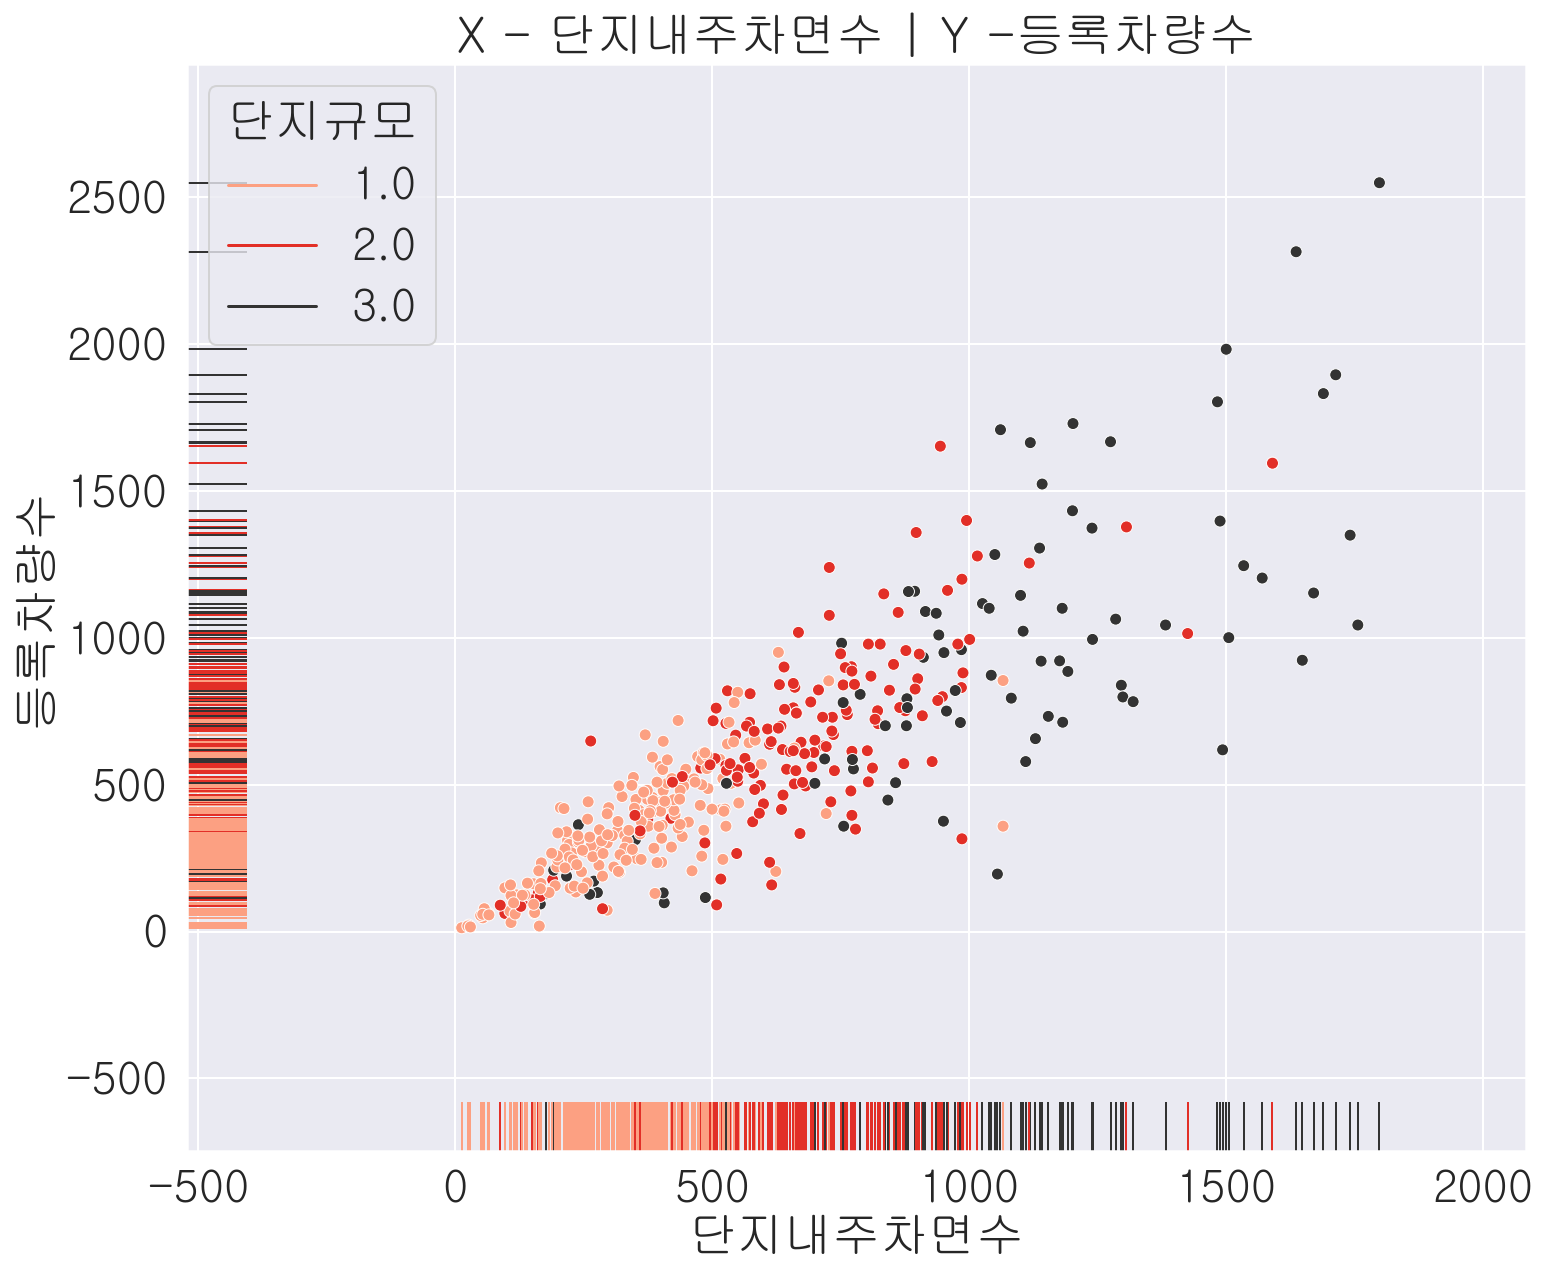

In [215]:
plt.figure(figsize=(12, 10))
sns.set_theme(style='darkgrid', font='gulim', font_scale=2) # , palette= 'Reds'
sns.scatterplot(x='단지내주차면수', y='등록차량수', data=new_train, palette= 'Reds_d', hue='단지규모')
sns.rugplot(x='단지내주차면수', y='등록차량수', data=new_train, palette= 'Reds_d', hue='단지규모', height=.045, clip_on=False)
plt.plot()
plt.title('X - 단지내주차면수 | Y -등록차량수')
plt.show()

In [285]:
my_x = new_train['단지내주차면수']
my_y = new_train['등록차량수']
# y = x
# 좌표 (1, 1), (2, 2) .. (2500, 2500) 기준
# 3가지 경우의 수가 나옴
# ex) (10, 10)
# 같은 경우 (10, 10) - 동일 선상
# x좌표가 큰 경우(11, 10) - 아래
# y좌표가 큰 경우(10, 11)


0     1425.00000
1      624.00000
2     1285.00000
3      734.00000
4      645.00000
         ...    
418     66.00000
419    521.00000
420     25.00000
421     30.00000
422    166.00000
Name: 단지내주차면수, Length: 423, dtype: float64

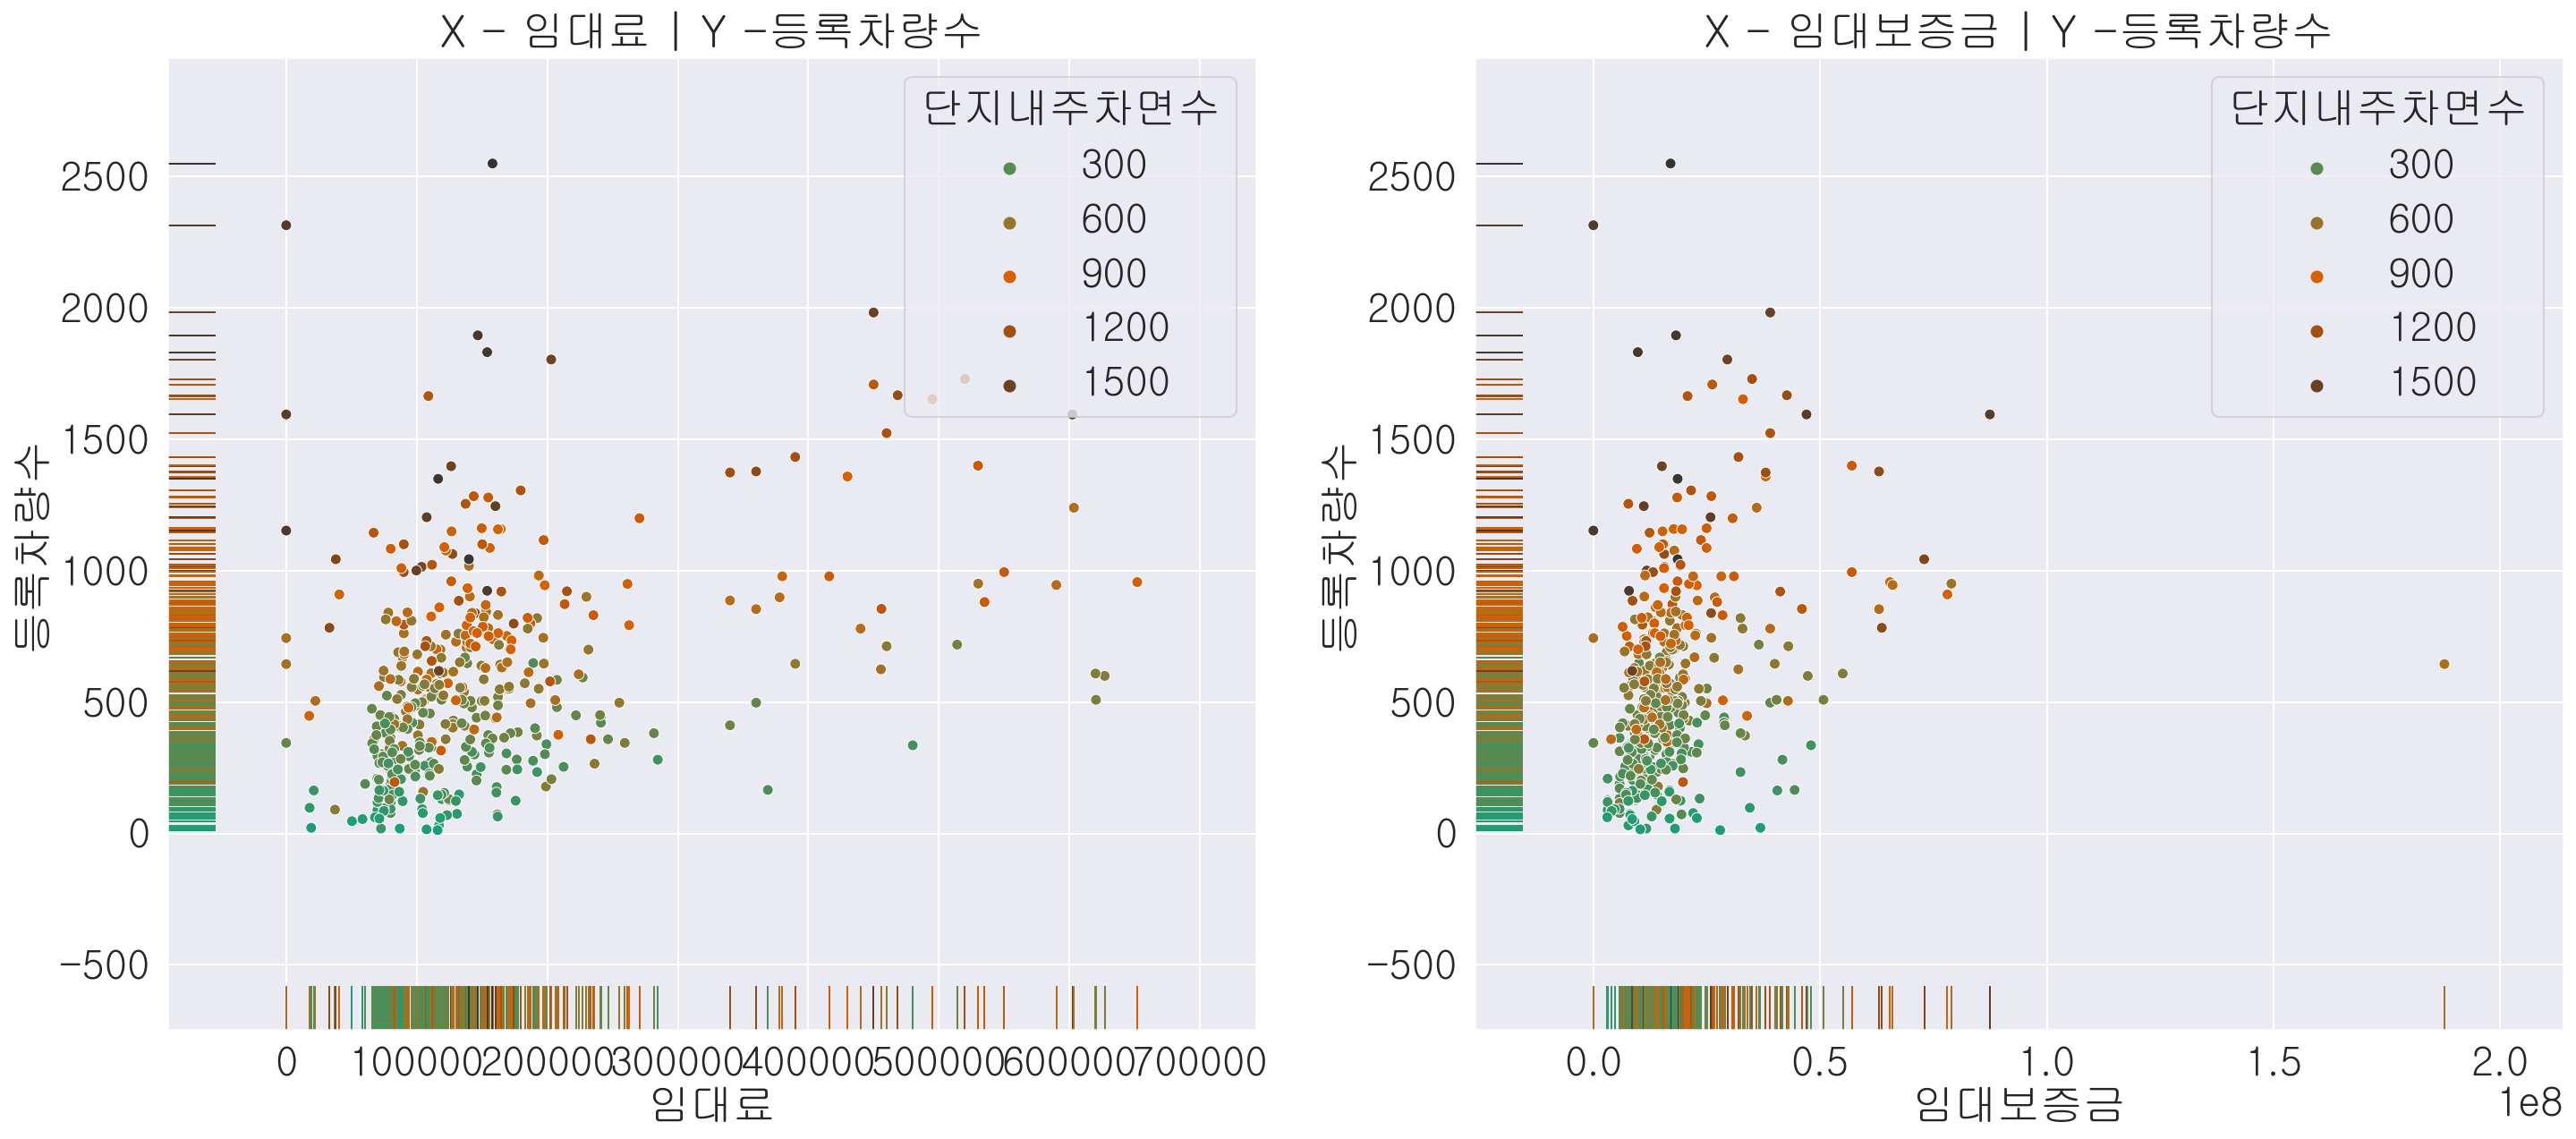

In [327]:
new_train_copy = new_train.copy()
new_train_copy['임대료'] = new_train_copy['임대료'] // 250
new_train_copy.loc[new_train_copy['임대보증금'] >= 1e8, '임대보증금'] = 8.74e7
new_train_copy['임대보증금'] = new_train_copy['임대보증금'] // 36000
new_train_copy['총세대수'] = np.exp(new_train_copy['총세대수'])
new_train_copy['공가수'] = new_train_copy['공가수'] * 45

plt.figure(figsize=(24, 10))
plt.subplot(1, 2, 1)
sns.set_theme(style='darkgrid', palette= 'Dark2_d', font='gulim', font_scale=2)
sns.scatterplot(x='임대료', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', hue='단지내주차면수')
sns.rugplot(x='임대료', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', height=.045, hue='단지내주차면수', clip_on=False, legend=False)
plt.title('X - 임대료 | Y -등록차량수')

plt.subplot(1, 2, 2)
sns.set_theme(style='darkgrid', palette= 'Dark2_d', font='gulim', font_scale=2)
sns.scatterplot(x='임대보증금', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', hue='단지내주차면수')
sns.rugplot(x='임대보증금', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', height=.045, hue='단지내주차면수', clip_on=False, legend=False)
plt.title('X - 임대보증금 | Y -등록차량수')

plt.show()

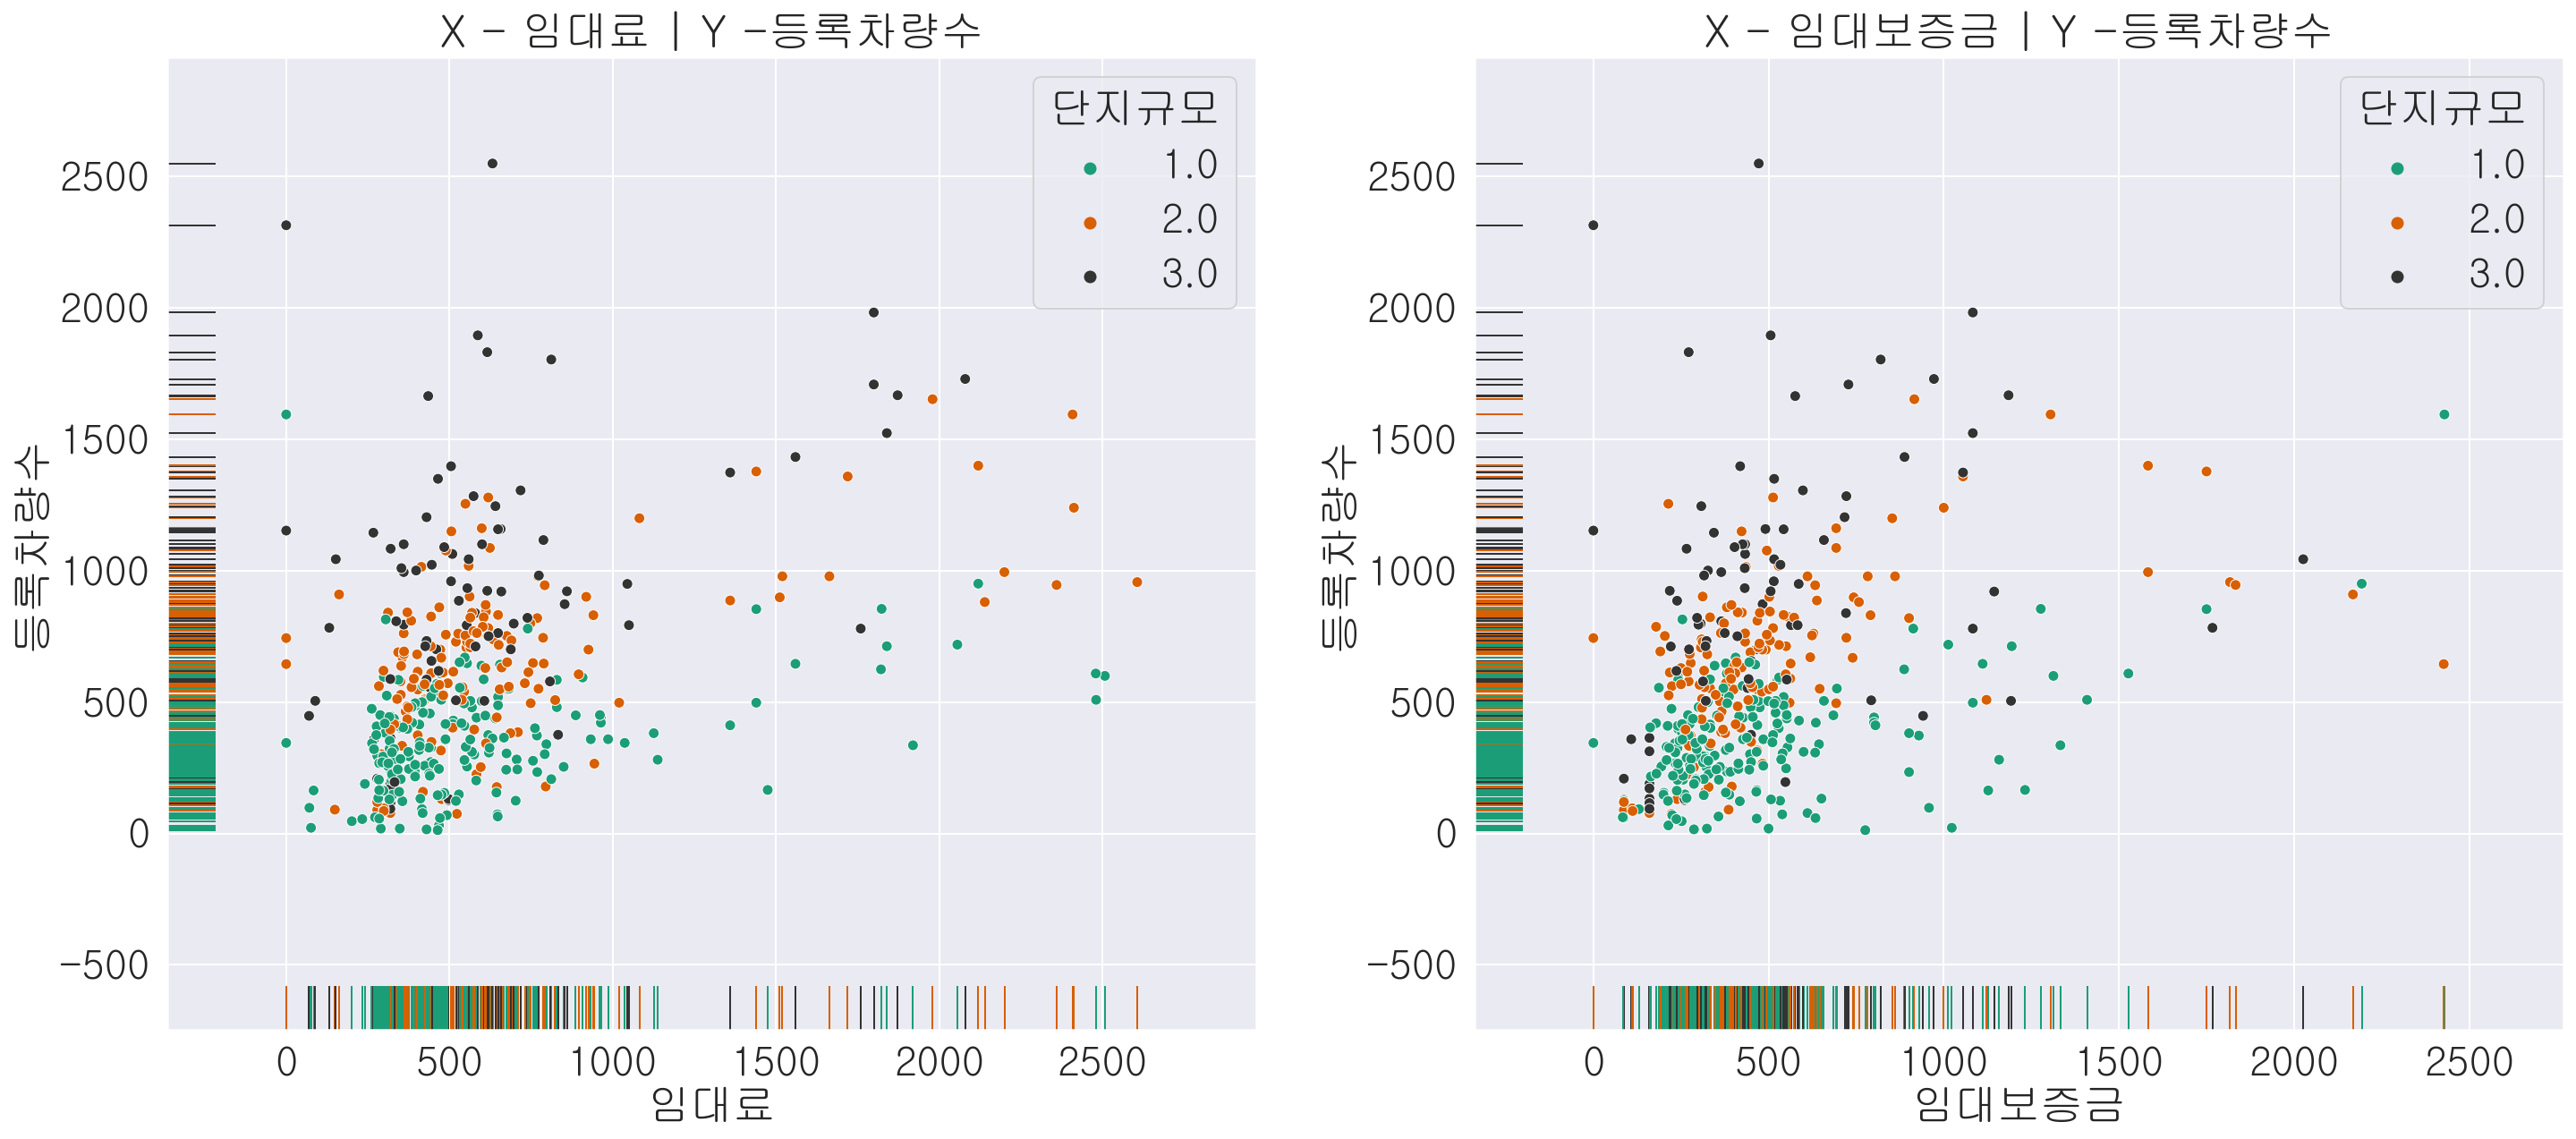

In [195]:
plt.figure(figsize=(24, 10))
plt.subplot(1, 2, 1)
sns.set_theme(style='darkgrid', palette= 'Dark2_d', font='gulim', font_scale=2)
sns.scatterplot(x='임대료', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', hue='단지규모')
sns.rugplot(x='임대료', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', height=.045, hue='단지규모', clip_on=False, legend=False)
plt.title('X - 임대료 | Y -등록차량수')

plt.subplot(1, 2, 2)
sns.set_theme(style='darkgrid', palette= 'Dark2_d', font='gulim', font_scale=2)
sns.scatterplot(x='임대보증금', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', hue='단지규모')
sns.rugplot(x='임대보증금', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', height=.045, hue='단지규모', clip_on=False, legend=False)
plt.title('X - 임대보증금 | Y -등록차량수')

plt.show()

In [196]:
new_train_copy.columns

Index(['임대보증금', '임대료', '총세대수', '지역', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수',
       '단지규모', '면적_35.0', '면적_50.0', '면적_55.0', '면적_30.0', '면적_45.0',
       '면적_40.0', '면적_25.0', '면적_70.0', '면적_15.0', '면적_20.0', '면적_100.0',
       '면적_60.0', '면적_75.0', '면적_80.0', '면적_65.0', '등록차량수'],
      dtype='object')

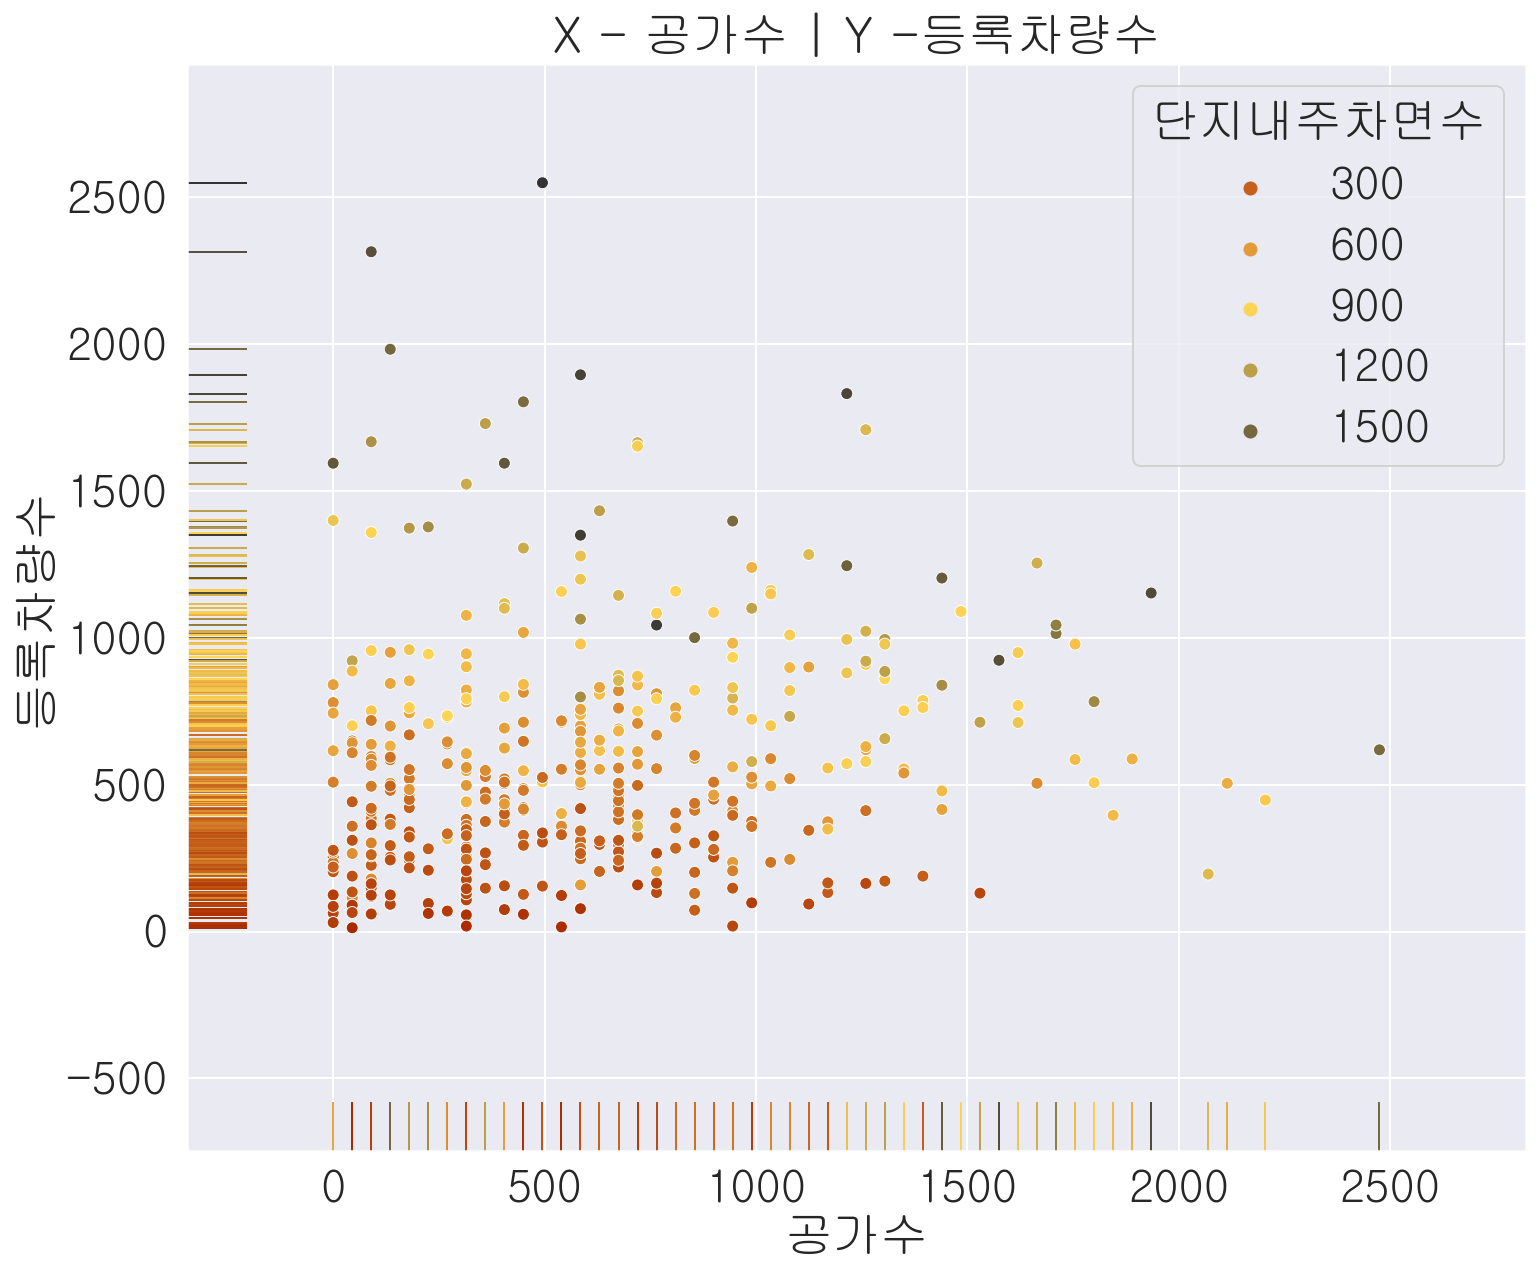

In [286]:
new_train_copy = new_train.copy()
new_train_copy['임대료'] = new_train_copy['임대료'] // 250
new_train_copy.loc[new_train_copy['임대보증금'] >= 1e8, '임대보증금'] = 8.74e7
new_train_copy['임대보증금'] = new_train_copy['임대보증금'] // 36000
new_train_copy['총세대수'] = np.exp(new_train_copy['총세대수'])
new_train_copy['공가수'] = new_train_copy['공가수'] * 45

plt.figure(figsize=(12, 10))
sns.set_theme(style='darkgrid', palette= 'afmhot_d', font='gulim', font_scale=2)
sns.scatterplot(x='공가수', y='등록차량수', data=new_train_copy, palette= 'afmhot_d', hue='단지내주차면수')
sns.rugplot(x='공가수', y='등록차량수', data=new_train_copy, palette= 'afmhot_d', height=.045, hue='단지내주차면수', clip_on=False, legend=False)
plt.title('X - 공가수 | Y -등록차량수')
plt.show()

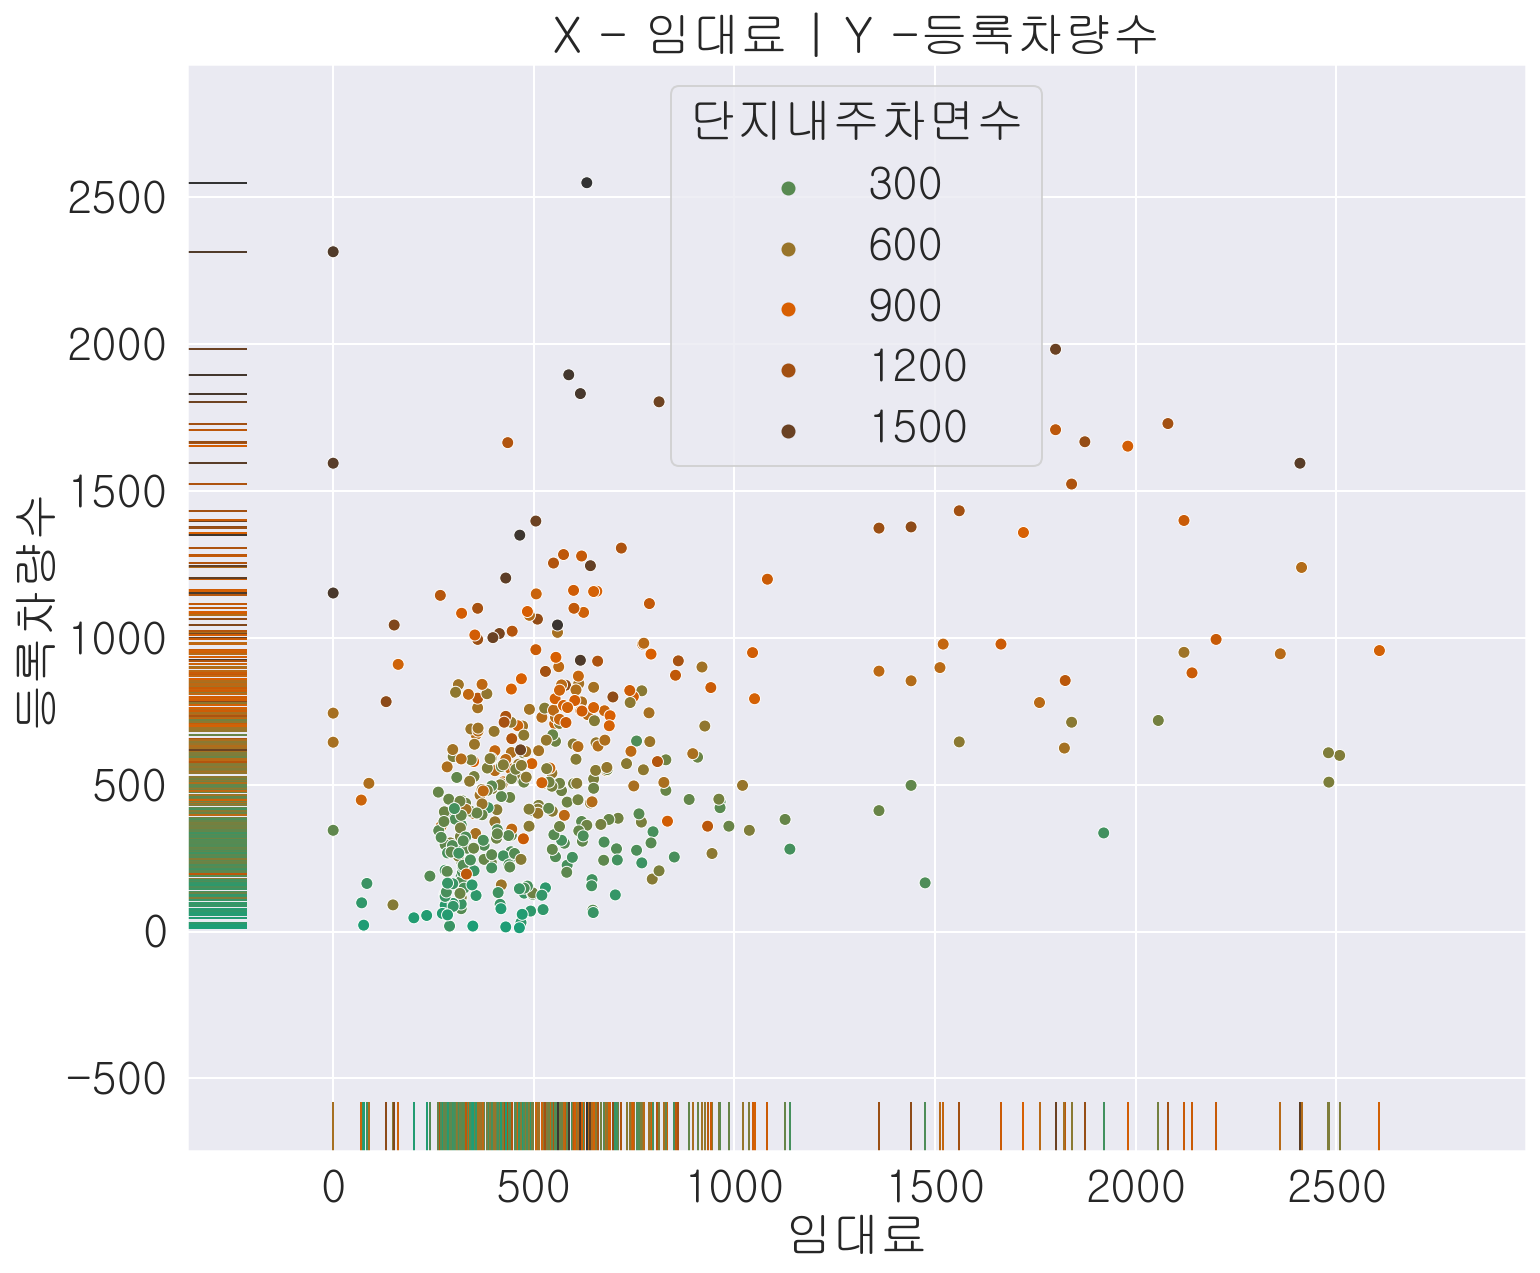

In [198]:
new_train_copy = new_train.copy()
new_train_copy['임대료'] = new_train_copy['임대료'] // 250
new_train_copy.loc[new_train_copy['임대보증금'] >= 1e8, '임대보증금'] = 8.74e7
new_train_copy['임대보증금'] = new_train_copy['임대보증금'] // 36000
new_train_copy['총세대수'] = np.exp(new_train_copy['총세대수'])
new_train_copy['공가수'] = new_train_copy['공가수'] * 45

plt.figure(figsize=(12, 10))
sns.set_theme(style='darkgrid', palette= 'Dark2_d', font='gulim', font_scale=2)
sns.scatterplot(x='임대료', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', hue='단지내주차면수')
sns.rugplot(x='임대료', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', height=.045, hue='단지내주차면수', clip_on=False, legend=False)
plt.title('X - 임대료 | Y -등록차량수')
plt.show()

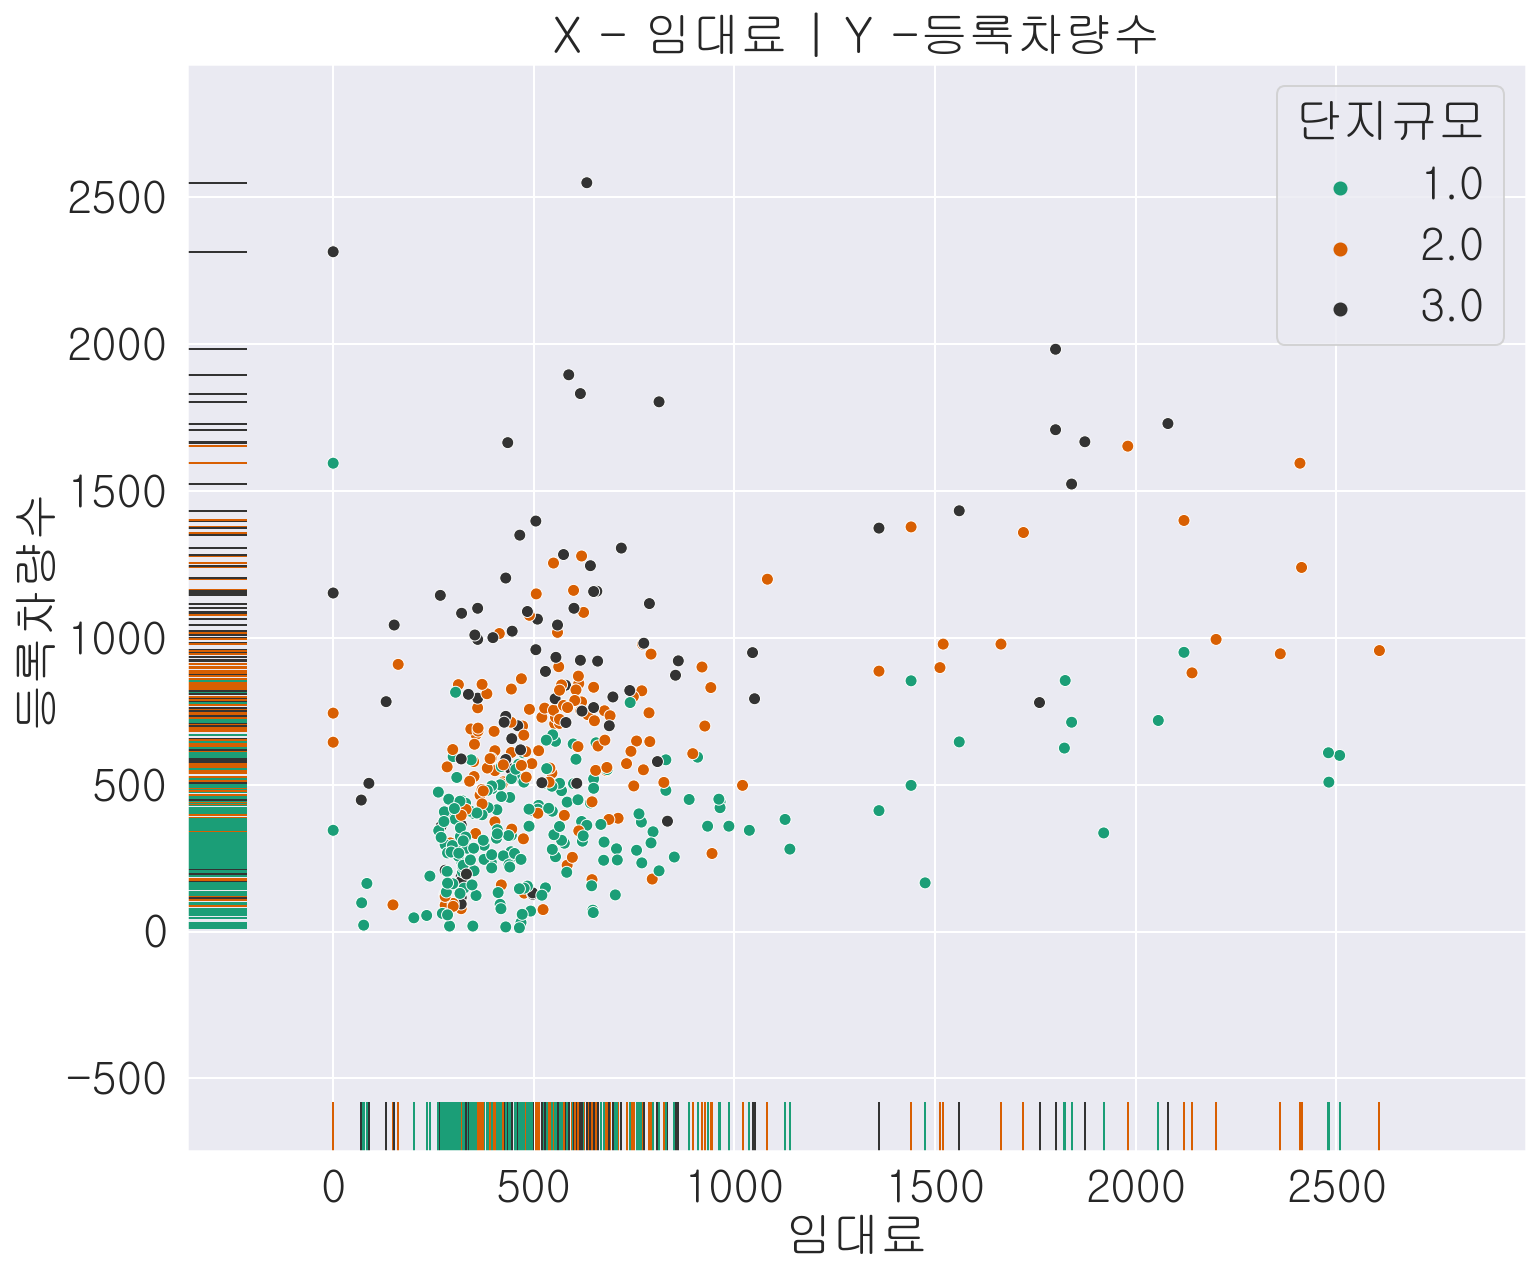

In [199]:
new_train_copy = new_train.copy()
new_train_copy['임대료'] = new_train_copy['임대료'] // 250
new_train_copy.loc[new_train_copy['임대보증금'] >= 1e8, '임대보증금'] = 8.74e7
new_train_copy['임대보증금'] = new_train_copy['임대보증금'] // 36000
new_train_copy['총세대수'] = np.exp(new_train_copy['총세대수'])
new_train_copy['공가수'] = new_train_copy['공가수'] * 45

plt.figure(figsize=(12, 10))
sns.set_theme(style='darkgrid', palette= 'Dark2_d', font='gulim', font_scale=2)
sns.scatterplot(x='임대료', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', hue='단지규모')
sns.rugplot(x='임대료', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', height=.045, hue='단지규모', clip_on=False, legend=False)
plt.title('X - 임대료 | Y -등록차량수')
plt.show()

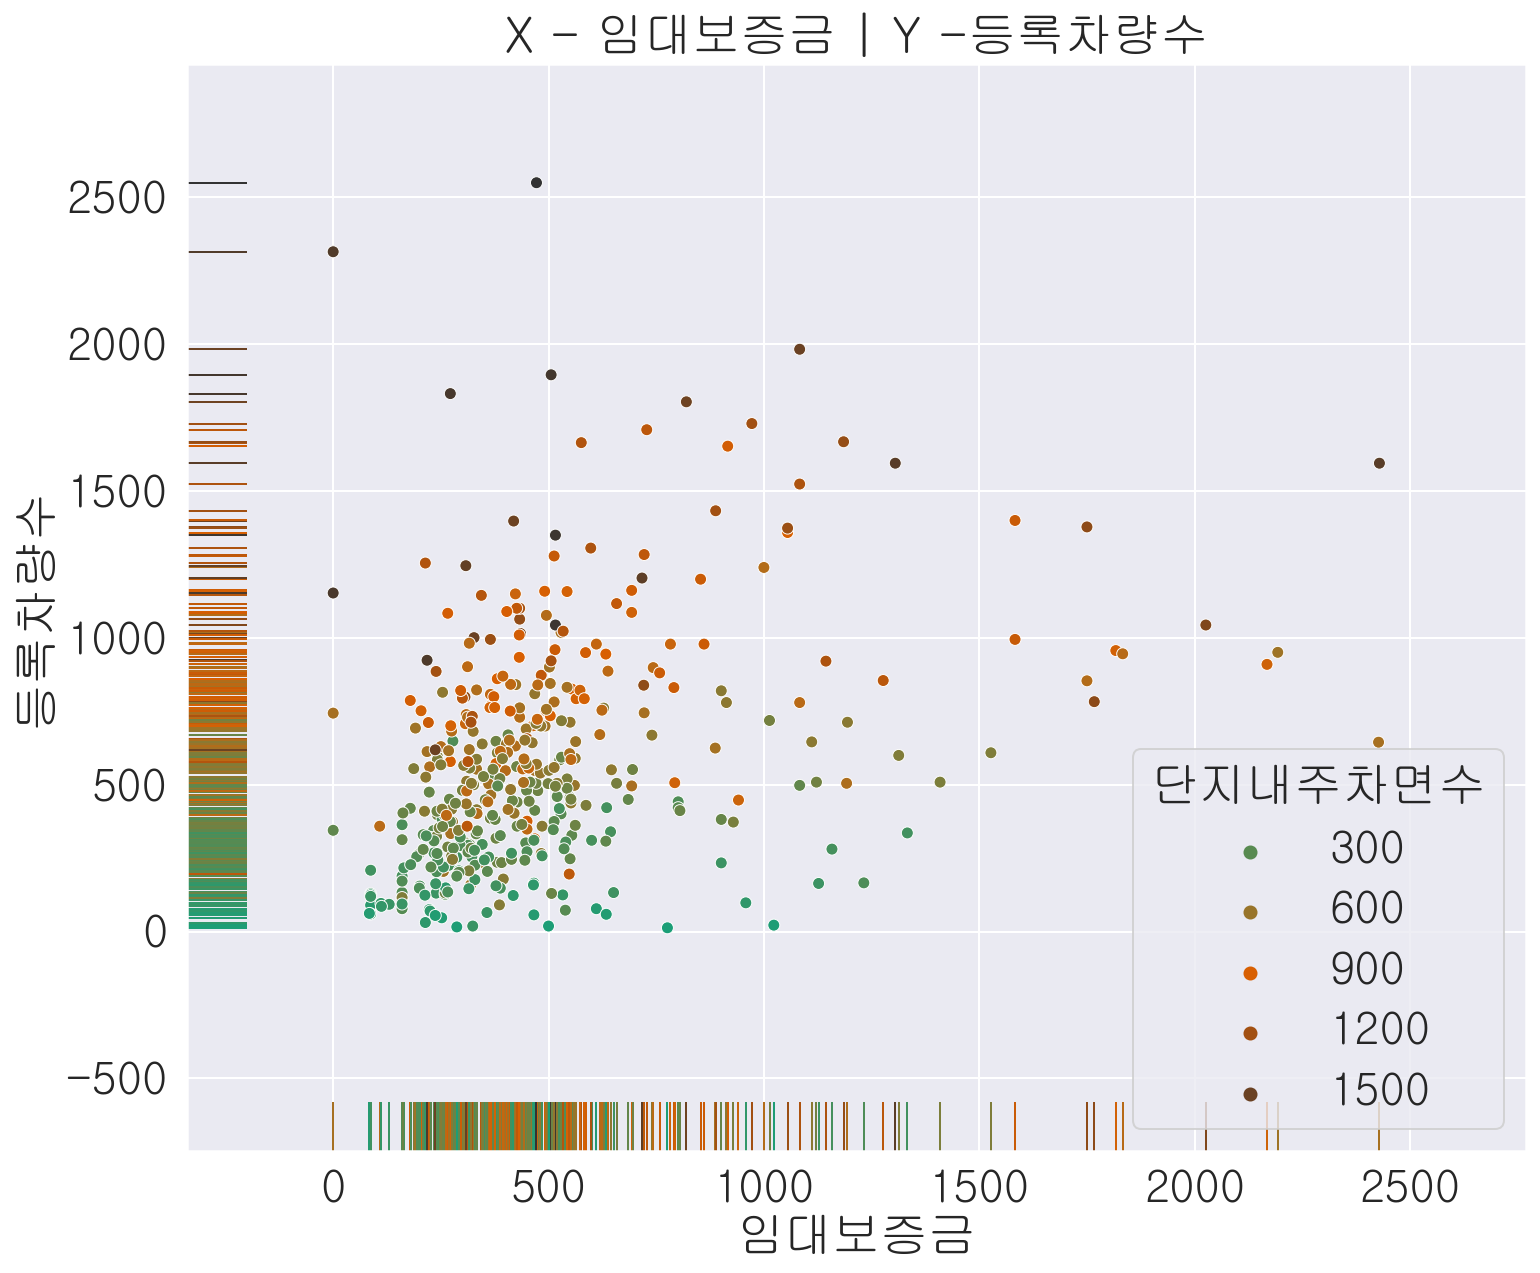

In [200]:
new_train_copy = new_train.copy()
new_train_copy['임대료'] = new_train_copy['임대료'] // 250
new_train_copy.loc[new_train_copy['임대보증금'] >= 1e8, '임대보증금'] = 8.74e7
new_train_copy['임대보증금'] = new_train_copy['임대보증금'] // 36000
new_train_copy['총세대수'] = np.exp(new_train_copy['총세대수'])
new_train_copy['공가수'] = new_train_copy['공가수'] * 45

plt.figure(figsize=(12, 10))
sns.set_theme(style='darkgrid', palette= 'Dark2_d', font='gulim', font_scale=2)
sns.scatterplot(x='임대보증금', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', hue='단지내주차면수')
sns.rugplot(x='임대보증금', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', height=.045, hue='단지내주차면수', clip_on=False, legend=False)
plt.title('X - 임대보증금 | Y -등록차량수')
plt.show()

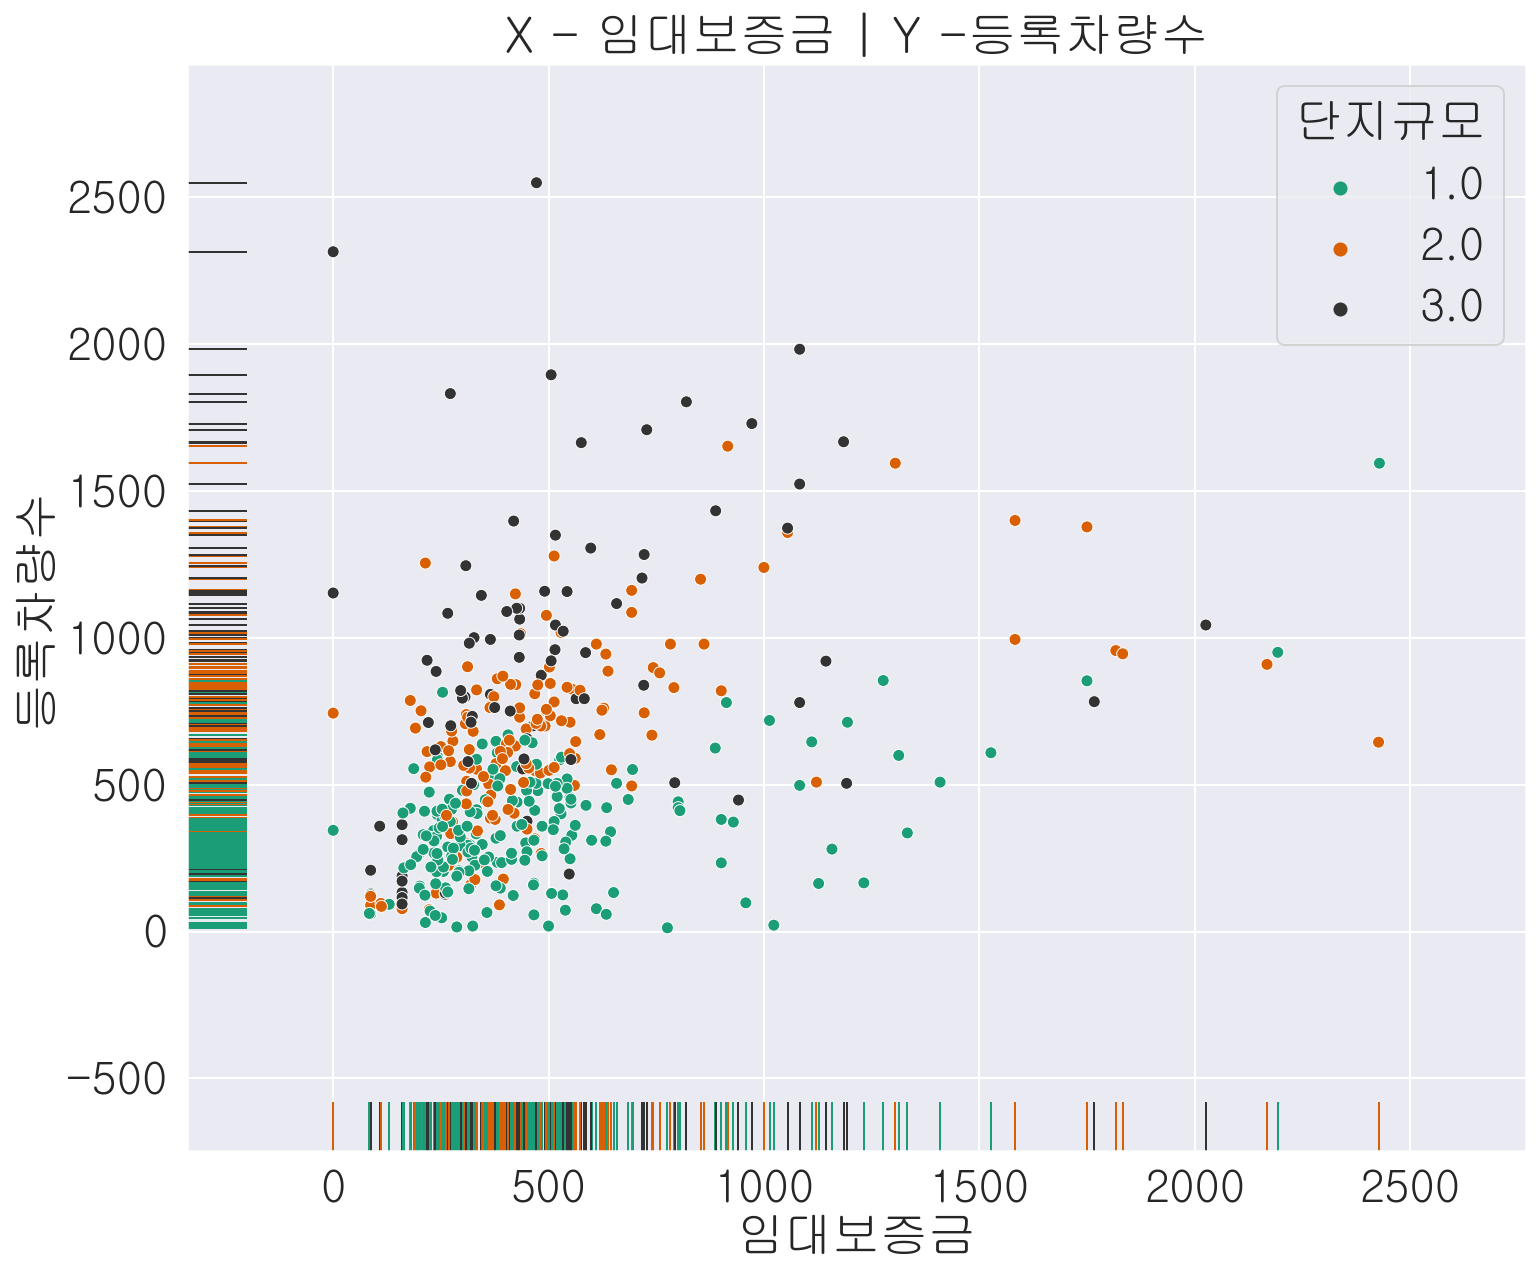

In [201]:
new_train_copy = new_train.copy()
new_train_copy['임대료'] = new_train_copy['임대료'] // 250
new_train_copy.loc[new_train_copy['임대보증금'] >= 1e8, '임대보증금'] = 8.74e7
new_train_copy['임대보증금'] = new_train_copy['임대보증금'] // 36000
new_train_copy['총세대수'] = np.exp(new_train_copy['총세대수'])
new_train_copy['공가수'] = new_train_copy['공가수'] * 45

plt.figure(figsize=(12, 10))
sns.set_theme(style='darkgrid', palette= 'Dark2_d', font='gulim', font_scale=2)
sns.scatterplot(x='임대보증금', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', hue='단지규모')
sns.rugplot(x='임대보증금', y='등록차량수', data=new_train_copy, palette= 'Dark2_d', height=.045, hue='단지규모', clip_on=False, legend=False)
plt.title('X - 임대보증금 | Y -등록차량수')
plt.show()